# **Proper Orthogonal Decomposition (POD)**
This Lab focuses on performing POD on the parametric system we saw together in the previous Lab.

Once again, we need _a lot_ of FOM simulations this time. Let us import ``gedim``!

In [1]:
import sys
sys.path.append('/content/CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

The same problem of the other lab, we have two different parameter $\mu_1$, in the inner disk, and $\mu_2$ outside. We have omogenius Dirichlet e Neumann on the border, but also non omogenious one.

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{base}\\
u = 0 & \text{in } \Gamma_{top}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k_{\mu} = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise. 
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.

The parameter $\boldsymbol \mu \in \mathcal P$ is physical and changes the features of the flow: 

1. $\mu_1$ the conductivity in $\Omega_1$;
2. $\mu_2$ describes the heat flux in the bottom part of the boundary.

First thing: we define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk in the origin with radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$.
3. $\Gamma_{base}$ to define where we will change the heat flux.


In [4]:
def Heat_R():
	return 0.5

def Omega1(numPoints, points): # Inside
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0.
	return values.ctypes.data

def Omega2(numPoints, points): # Outised
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def Gamma_base(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

##### needed for the inner product #####

def Domain(numPoints, points): # We need something that is defined all over the domain
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints) # All the value setted as one
	return values.ctypes.data	

**GOAL OF A MODEL ORDER REDUCTION**: it's a double discretization strategy, that works for a fixed mash, fixed degree of fredom.

**Goal**: build the ROM space where many simulations for several parameters can be performed in a smaller amount of time. 

**Strategy**: $w(\boldsymbol  \mu)  \xrightarrow[]{\text{FOM} (\dim = \mathcal N)} w^{\mathcal N}(\boldsymbol \mu)
\xrightarrow[\lvert \lvert {w(\boldsymbol \mu) - w^\mathcal{N}(\boldsymbol  \mu)\rvert \rvert } \rightarrow 0]{\text{ROM } (\dim N)} w_N(\boldsymbol  \mu)$. Where $\mathcal N$ is the $N\delta$, that is the bigger space, on the contrary $N$ is the smaller space, so we have $N \ll \mathcal N$.

We want to compute $||w(\mu)-w_N(\mu)|| = |||w(\mu)-w^{\mathcal N}(\mu))+w^{\mathcal N}(\mu))-w_N(\mu)|| \leq ||w(\mu)-w^{\mathcal N}(\mu)||+||w^{\mathcal N}(\mu)-w_N(\mu)|| = 0 + ||w^{\mathcal N}(\mu)-w_N(\mu)||$, using triangular inequality and $w$ represents the solution.

A *snapshot* is a solution $w$ for a fixed set of parameters $\mu$.

The goal can be reached by means of several techniques. 

Today we will focus on **POD**.

POD is an _explore_ and _compress_ algorithm based on two different stages:
1. we _explore_ the information related to the solution varying with respect to $\boldsymbol \mu$ (_snapshots_) in a finite dimensional set $\mathcal P_{train} \subset \mathcal P$.
2. We compress the redundant information and retain only the most significant "linear directions", building a linear subspace $\mathbb V_N \subset \mathbb V^{\mathcal N}$ of dimension $N \ll \mathcal N$.

Building the space and store the $\boldsymbol \mu$-independent quantities is the so called _offline phase_ (possibly costly).

Once the space is built, a fast _online phase_ occurs, where I can compute **many solutions in real-time**.

How is it possible? **Separations of variables**: by means of **the affine decomposition**! Indeed we know that our system can be written as

$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)a_i(u,v) = \sum_{i=0}^{q_f} \theta_i^f(\boldsymbol \mu)f_i(v),
$$

i.e., algebraic-wise

$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)\mathsf A_i = \sum_{i=0}^{q_f} \theta_i^f(\boldsymbol \mu)\mathsf f_i,
$$
where $\mathsf A_i$ and $\mathsf f_i$ are the assembled matrices and vectors of the system.

Now, let us imagine to have already built the reduced space and have collected the *basis functions* (always related to the snapshot, is a vector in the $\mathcal N$ space) $\xi_{i} \in \mathbb R^{\mathcal N}$ for $i \in \{1, \dots, N \}$ ($\mathbb V_N = \text{span}\{\xi_i\}_{i=1}^{N} $) in a basis matrix 
$$
\mathbb B = [\xi_1 | \cdots | \xi_N] \in \mathbb R^{\mathcal N \times N}.
$$ 
in which $\xi_j$ are concatenated orizzontally and $\xi_j \in \mathbb R^{\mathcal N} \; \forall j \in N$.

It is clear that we can recast the problem in the low-dimensional framework we built, we can pre-and-post multiply the FOM matrices for the basis matrix we have:

$$
\mathsf A_i^N = \mathbb B^T\mathsf A_i\mathbb B \quad \text{ and } \quad  \mathbb B^T\mathsf f_i.  
$$
So we have just projected in a smallest space building this new matrix $\mathsf A_i^N$ that is similar to the bigger one $\mathsf A_i$ (think of Hilbert space).

**Here is where the offline phase ends!!**

**Question time!**: where did it start? It started when we look all the snapshot together, after we project in a smaller basis, and here it finishs.

**Let us code the OFFLINE PHASE**

In [ ]:
### order of the discretization ###
order = 1 # Linear finite element approximation

# Importing the mesh in the next cell

In [9]:
%%writefile ImportMesh.csv
InputFolderPath
/content/CppToPython/Meshes/Mesh3

Overwriting ImportMesh.csv


In [10]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

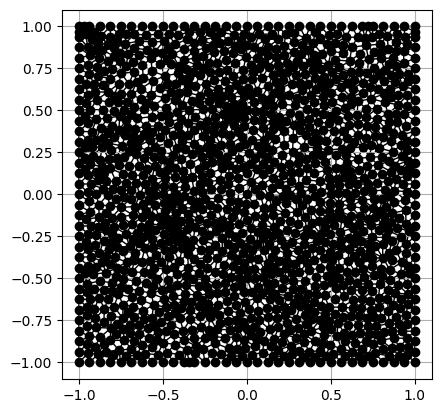

In [11]:
gedim.PlotMesh(mesh)

### FEM space (the High Fidelity approximation)

In [12]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

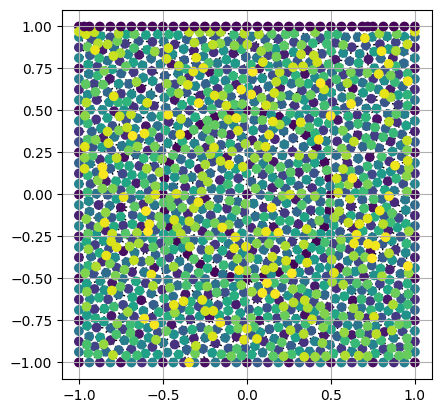

In [13]:
gedim.PlotDofs(mesh, dofs, strongs)

### Assemble linear system exploting affinity
We define everything that is parameter independent, i.e.
$a_1(u,v)$, $a_2(u,v)$ and $f(v)$.
We need also the matrix related to the scalar product of the problem at hand.

**How to assemble the linear system?** 
$$
\int_{\Omega_1} \nabla u \nabla v dx + \mu_1 \int_{\Omega_2} \nabla u \nabla v dx = \int_{\Gamma_{base}} \mu_2 v ds \forall v \in V
$$

*Recap Hilbert spaces.*
- $L^2(\Omega) = \{ u st ||u||_{L^2(\Omega)} = ||u||^2 = <u,u>_{L^2(\Omega)} = \int_{\Omega} u^2 dx < +inf\}$: means that conteins all the functions that are integrable 
- $H^1(\Omega) = \{ u \in L^2 st ||\nabla u|| < + \inf\} $: means that conteins functions the are integrable and also their gradients are gradient

We want to work now on $H^1$ space, using the inner product of $H^1$.

In [ ]:
# We assemble here the linear system
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega2, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega1, problemData, lib)
	
weakTerm_down1 = gedim.AssembleWeakTerm(Gamma_base, 1, problemData, lib)

#### inner product  
# ||u||^2 + ||grad(u)||^2

# [reaction, reactionStrong] = gedim.AssembleReactionMatrix(Domain, problemData, lib)
# Reaction = is the part related tu L^2, so just the integration of u
# Indeed, when we compiut the inner product we have to focus on ||u||^2 (Reaction) and on ||grad(u)||^2 (inner_product)

inner_product = stiffness1 + stiffness2  ######## semi-norm (equivalent)

We here define the finite parametric space $\mathcal P_{train}$, with random uniform distributed realization of $\boldsymbol \mu$.
The cardinality of $\mathcal P_{train}$ is set to 100 and we call it $M$.

In [ ]:
### define the training set

snapshot_num = 100 # (M = number of snapshot) we are search 100 solution
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]
P = np.array([mu1_range, mu2_range])

# Uniform distribution, I have the same probability to peak all the numbers
training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0])) 

We now need to define the _snapshot matrix_. The snapshot matrix is $\mathbb U \in \mathbb R^{{M} \times {\mathcal N}}$ 

In [ ]:
#### snapshot matrix creation
thetaA1 = 1.
snapshot_matrix = []

tol = 1. - 1e-7 # Pay attention: the tol is defined as 1 - 1e-7
N_max = 10

for mu in training_set: # For all the parameters (my 100)
    # I compute the integral that I write before
  thetaA2 = mu[0]
  thetaf1 = mu[1]

  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  
  snapshot = gedim.LUSolver(stiffness, weakTerm_down, lib)
  
  snapshot_matrix.append(np.copy(snapshot))

snapshot_matrix = np.array(snapshot_matrix) 

print(snapshot_matrix.shape) # All the snapshot x dimension of the space

(100, 1453)


**It's time for the POD**

We works with *correlation matrix*, that is defined as $snapshot_matrix \times snapshot_matrix$. **Positive things**: all the eigen value are positive and also ordinable.

To build the $N$-dimesional framework we need, we define the correlation snapshot matrix $\mathbf C \in \mathbb R^{M \times M}$ and we solve the eigenvalue problem
$
    \mathbf C \omega_n = \lambda_n \omega_n
$ for $ 1 \leq n \leq M,$ with $\lvert \lvert {\omega_n}\rvert \rvert_{\mathbb V} = 1$. 
Due to the definition of correlation matrix, we can order the all-positive eigenvalues as $\lambda_1 >\dots > \lambda_{M}> 0$ and retain the first $N$ eigenpairs $(\lambda_n, \omega_n)$ for $1 \leq n \leq N$. 

**Question Time**: how can I choose $M$ and $N$? So how can i chose the number of snapshot? The more the best so that I can have more information, but i have to trade-off to the computational effort -> depends on the problems. And how to chose the number of basis? We have to look at the eigenvalues. 

Looking at the eigenvalues! 
Indeed, defining as  $P_N: \mathbb V \rightarrow \mathbb V_N$ the projector from $\mathbb V$ onto $ {\mathbb V}_N$, the following relation holds:
\begin{equation}
    \sqrt{\frac{1}{M}
    \sum_{i = 1}^{M}  \lvert \lvert {u^{\mathcal N}(\boldsymbol{\mu}_{i}) - P_N(u^{\mathcal N}(\boldsymbol{\mu}_i))\rvert \rvert }_{2}^2} = \sqrt{
    \sum_{i = N + 1}^{M}\lambda_m.}
\end{equation}
Namely, a fast decay of the eigenvalue magnitude guaratees a good representation of the high-fidelity solution with a few basis functions. Where $P_N$ is the projection.

So this theorem tells us that the error that we compute is very small if we do not take in consideration the eigenvalues that are really small.

Here, we can work with SVD or POD, it's better POD for the structure of the covariance matrix.

In [ ]:
### covariance matrix
# What is the inner_product in between? 
# 1. (u,v)_L^2 = u'v in L^2 is a scalar number
# 2. (u,v)_A = u'Av is the inner prodoct of a matrix A
# 3. (u,v)_H^1 = u'Xv where X is the inner prodoct matrix 
# --> I'm looking the solutions in this product, for that reason I need X = inner_product = stiffness1 + stiffness2

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 

###### shape?? -> number_of_snapshot x number_of_snapshot ############ 

#### ALTERNATIVE:  VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check


for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # We need a symmetic positive definite matrix: all eigenvalues real and positive
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues) # Sum of all the eigenvalues
retained_energy_vector = np.cumsum(eigenvalues) # Cumulative sum (summing until n)
relative_retained_energy = retained_energy_vector/total_energy # "Percentage"

# The IDEA is: we have a tol = 1 - 1e-7, the first time that relative_retained_energy 
# (that is the sum of the eigenvalue) is
# bigger than the tol, I can stop the computation and study the problem in 
# that number of dimenison
# Hence, all the other eigenvalue (and so direction) are NOT relevant to 
# compute the solution

# We want the first term for that the relative_retained_energy is less then 1 - 1e-7
if all(flag==False for flag in relative_retained_energy>= tol): 
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1 # Python works from 0, but the basis goes from 1

# I need 3 basis (see the resutl) to show everything, this means that with 3 
# eigenvalues we reach the condition, and all the other are very very small (irrelevant)
print("The reduced dimension is", N) 

The reduced dimension is 3


**Comment the result of previuous cell**. 
$$
relative\_retained\_energy = \frac{\sum_i^N(\lambda_i)}{\sum_j^M(\lambda_j)}
$$
where $N$ is not fixed, but $N \in \{1, \dots, M\}$. 
The first time that we achieve _relative_retained_energy>= tol_ we understand what is the number of the dimension in which we can reduced the space.

We still need to create the basis matrix $\mathbb B$. There are many ways to build the bases.
We propose the following one to guarantee more stability:
$$    
\chi_n =  \sum_{m = 1}^{M} (\omega_n)_m u^{\mathcal N}(\boldsymbol{\mu}_m),  \quad \quad 1 \leq n \leq N,
$$

and $\displaystyle \xi_n = \frac{\chi_n}{\lvert \lvert \chi_n \rvert \rvert }_{\mathbb V}$.


$P_N: \mathbb V \rightarrow \mathbb V_N$ is defined as

$$
P_N(u^{\mathcal N}(\boldsymbol \mu)) = \sum_{i=1}^N (u^{\mathcal N}(\boldsymbol \mu), \xi_n)\xi_n,
$$

or algebraically $\mathbb P_N = \mathbb B \mathbb B^T$.

In [ ]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  # basis = (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  
  # (This is the one of the book!!)
  
  basis = np.transpose(snapshot_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) # ||u||_H^1 = u'Xu 
  
  basis /= norm # Normalizing
  basis_functions.append(np.copy(basis)) # Have all together all the basis

basis_functions = np.transpose(np.array(basis_functions))


The offline stage ends once the **reduced operators** are built, i.e. $\mathsf A_1^{N}$, $\mathsf A_2^{N}$ and $\mathsf f_1^{N}$ thanks to the basis matrix projections.

In [ ]:
########## ASSEMBLE THE LINEAR SYSTEM ##### STILL OFFLINE
# Reduce operator
reduced_stiff1 = np.transpose(basis_functions) @ stiffness1 @ basis_functions
reduced_stiff2 = np.transpose(basis_functions) @ stiffness2 @ basis_functions

reduced_f =  np.transpose(basis_functions) @ weakTerm_down1 # The reduced f

### shape? ##### 

### **Online Phase: a new parameter!** ###
In the _online phase_ we can use all the pre-assembled quantities to generate a new solution for a new parameter. 



In [22]:
# Define theta
thetaA2 = 2.
thetaf1 = 0.8

In [23]:
# Work in the reduce space, everithing depends on the stored matrix that we build 3x3
reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2
reduced_lhs = thetaf1*reduced_f

In [25]:
##### solve ######### 

reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
print(reduced_solution) # Vector of a 3 component

[ 0.34411647  0.86284147 -0.20314192]


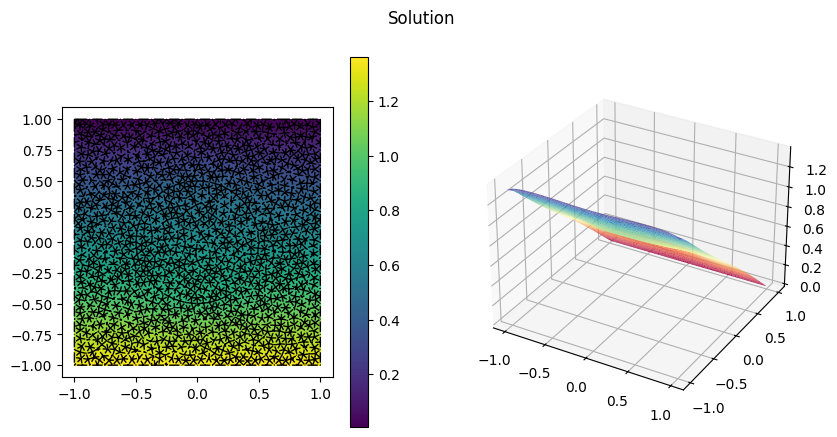

In [ ]:
###### plot #######
# I need to project reduced_solution back to the finite element space (calligraphic N)
proj_reduced_solution = basis_functions @ reduced_solution 

# plot the reduce solution projected
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, np.zeros(problemData['NumberStrongs'])) 
stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
weakTerm_down = thetaf1*weakTerm_down1

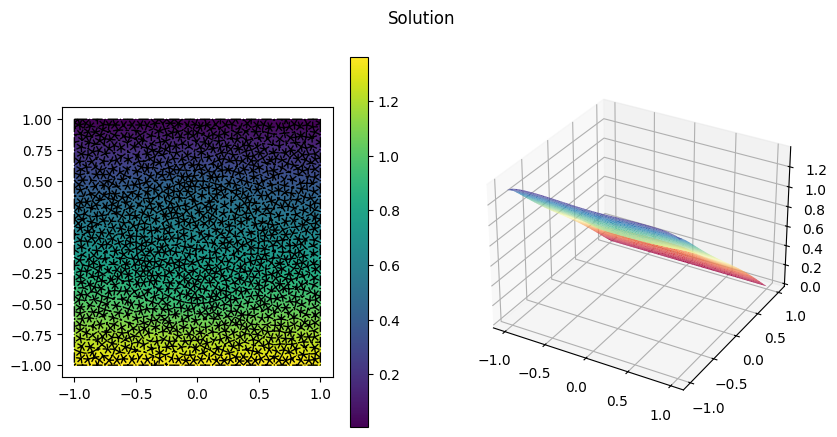

In [29]:
# Full solution
full_solution = gedim.LUSolver(stiffness, weakTerm_down, lib) 
gedim.PlotSolution(mesh, dofs, strongs, full_solution, np.zeros(problemData['NumberStrongs'])) 

We can now compute an error analysis over the parametric space, together with a _speed-up_ anaslysis.

The speed-up is an index that evaluated how many ROM solution I can obtain in the time of a FOM (Full Order Model) simulation.

In [ ]:
### compute error
# Take the ROM and FOM time and computer FOM/ROM time to undersand how faster ROM is
# We want to build a model that is
# 1. Accurate
# 2. Rapid

import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
  # Compute the thetas
  thetaA2 = mu[0]
  thetaf1 = mu[1]

  ##### full #####
  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2 # Separation of variables
  weakTerm_down = thetaf1*weakTerm_down1
  
  start_fom = time.time()
  full_solution = gedim.LUSolver(stiffness, weakTerm_down, lib)
  time_fom = time.time() - start_fom

  #### reduced #####

  # Reduced assemble in the offline fase (already stored in my memory)
  reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2 
  reduced_lhs = thetaf1*reduced_f
  
  start_rom = time.time()
  reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
  time_rom = time.time() - start_rom
  
  speed_up.append(time_fom/time_rom)  # FOM/ROM!
  
  proj_reduced_solution = basis_functions@reduced_solution

  ### computing error
  # ||u_delta - Bu_n||_H^1 = (u_delta-Bu_N)'X(u_delta-Bu_N)
  # Error of the solution that I computed in the reduced and full form 
  # (how much they are distance)
  error_function = full_solution - proj_reduced_solution 
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(full_solution) @  inner_product @ full_solution
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)

Computing error and speedup analysis


In [33]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) )

avarege relative error =  0.00011780990130384037
avarege absolute error =  9.979139219046532e-05
avarege speed_up =  247.02001093009295


**Exercise**: solve the same problem but with $u = 3$ on $\Gamma_{top}$.